## Boston AirBnB open data with the CRISP-DM (Cross Industry Process for Data Mining)

To get general AirBnB business insight, the Boston data from AirBnB will be analyzed based on the CRISP-DM. The subprocesses of the CRISP-DM are written below.

`1`. Business Understanding

`2`. Data Understanding

`3`. Prepare Data

`4`. Data Modeling

`5`. Evaluate the Results

`6`. Deploy

In [ ]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar #To check holidays in the U.S

In [46]:
# Load the AirBnB files
df_listing = pd.read_csv('./listings.csv')
df_calendar = pd.read_csv('./calendar.csv')
df_reviews = pd.read_csv('./reviews.csv')

## 1. Business Understanding

Major Questions 
    - What are the most relevant features of the groups over the 90 percentile and under the 10 percentile?
    - What are the most relevant features to be cared for the two traveler group and more than four traveler group?
    - How is the price of AirBnb adjusted in terms of seasons and locations?

## 2. Data Understanding

Check and play around the dataframes loaded before to get some idea or to get the business quesations progressed.

In [47]:
pd.set_option('display.max_columns', None)  

In [57]:
print(df_listing.shape)
df_listing.head(n=10)

(3585, 95)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United Sta

In [49]:
print("# of id:",df_listing.id.unique().size)
print("# of host_id:",df_listing.host_id.unique().size)
# There are some hosts who take care of more than two ids

# of id: 3585
# of host_id: 2181


# of accommodates: [ 4  2  3  5  1  8  6 16  7  9 10 12 11 14]
2     0.413668
4     0.181311
1     0.122455
3     0.119386
5     0.068340
6     0.056625
8     0.015342
7     0.010879
10    0.005300
9     0.002789
12    0.001395
11    0.001116
14    0.000837
16    0.000558
Name: accommodates, dtype: float64
Accomodates equal or less than 2 is 53.61 %
Accomodates more than 2 is 42.57 %


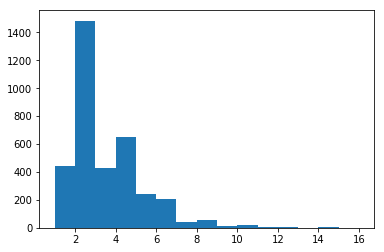

In [50]:
print("# of accommodates:",df_listing.accommodates.unique())
tmp = df_listing.accommodates.value_counts(ascending=False)/df_listing.accommodates.size
print(tmp)
print("Accomodates equal or less than 2 is {:5.2f} %".format((tmp[1]+tmp[2])*100))
print("Accomodates more than 2 is {:5.2f} %".format((tmp[3]+tmp[4]+tmp[5]+tmp[6])*100))
# 96% of total id can be categorized into the group with less than 2 people or the group with more than 2 people
plt.hist(df_listing.accommodates, bins=15)
plt.show()

In [51]:
print("# of bed_type:",df_listing.bed_type.unique())

# of bed_type: ['Real Bed' 'Pull-out Sofa' 'Futon' 'Airbed' 'Couch']


In [52]:
# Modify df_calendar for future work
# Special event : marathon, new academic season

def modify_calendar(df_calendar):
    '''
    Input : a Pandas dataframe having a date data column
    Output : a Pandas dataframe having year, month, day, weekday, us_holiday columns
    '''
    # Split date column into year, month,day, weekday columns
    # The day of the week with Monday=0, Sunday=6
    # Set the range of weekends from Friday to Sunday
    df_calendar['year'] = pd.DatetimeIndex(df_calendar['date']).year
    df_calendar['month'] = pd.DatetimeIndex(df_calendar['date']).month
    df_calendar['day'] = pd.DatetimeIndex(df_calendar['date']).day
    df_calendar['weekday'] = pd.DatetimeIndex(df_calendar['date']).weekday
    
    # Add weekend column
    weekend = [4,5,6]
    df_calendar['weekend'] = df_calendar.weekday.isin(weekend)
    
    # Replace values in weekday column 
    df_calendar['weekday'].replace({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday',4:'Friday', 5:'Saturday', 6:'Sunday'}, inplace=True)
    
    # Add us_holiday column
    cal = calendar()
    holidays = cal.holidays(start=df_calendar.date.min(), end=df_calendar.date.max())
    df_calendar['us_holiday'] = df_calendar.date.astype('datetime64').isin(holidays)
    
    return df_calendar

In [53]:
cal = calendar()
holidays = cal.holidays(start=df_calendar.date.min(), end=df_calendar.date.max())
print(holidays)

DatetimeIndex(['2016-10-10', '2016-11-11', '2016-11-24', '2016-12-26',
               '2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29',
               '2017-07-04', '2017-09-04'],
              dtype='datetime64[ns]', freq=None)


In [54]:
df_cal_modified = modify_calendar(df_calendar)
print(df_cal_modified.shape[0]/365)
df_cal_modified.tail(n=3)
# Each listing_id has 365 rows

3586.0


,listing_id,date,available,price,year,month,day,weekday,weekend,us_holiday
1308887,14504422,2016-09-08,f,NaN,2016,9,8,Thursday,False,False
1308888,14504422,2016-09-07,f,NaN,2016,9,7,Wednesday,False,False
1308889,14504422,2016-09-06,f,NaN,2016,9,6,Tuesday,False,False


In [63]:
 df_listing.id.unique()
# def count_available(df_cal_modified):
#     id_list = list(df_listing.id.unique())
    

numpy.ndarray

In [61]:
# 1. 먼저 df_cal_modified를 특정 listing_id로 dataframe 읽고,
# 2. 그 frame서 available t, f 값을 찾고,
# 3. t에서 주중에 t값, 주말, 혹은 휴일에 t값 및 각각의 price값을 읽고,
#4. 3을 listing_df에 update
tmp = df_cal_modified[(df_cal_modified.listing_id == 2843445)]
print(tmp.available.value_counts())
print(type(tmp.available.value_counts()))
print(tmp.available.value_counts()[0])
print(tmp.price.unique())

tmp

t    365
Name: available, dtype: int64
<class 'pandas.core.series.Series'>
365
['$75.00']
f    0.508716
t    0.491284
Name: available, dtype: float64


,listing_id,date,available,price,year,month,day,weekday,weekend,us_holiday
2555,2843445,2017-09-03,t,$75.00,2017,9,3,Sunday,True,False
2556,2843445,2017-09-02,t,$75.00,2017,9,2,Saturday,True,False
2557,2843445,2017-09-01,t,$75.00,2017,9,1,Friday,True,False
2558,2843445,2017-08-31,t,$75.00,2017,8,31,Thursday,False,False
2559,2843445,2017-08-30,t,$75.00,2017,8,30,Wednesday,False,False
2560,2843445,2017-08-29,t,$75.00,2017,8,29,Tuesday,False,False
2561,2843445,2017-08-28,t,$75.00,2017,8,28,Monday,False,False
2562,2843445,2017-08-27,t,$75.00,2017,8,27,Sunday,True,False
2563,2843445,2017-08-26,t,$75.00,2017,8,26,Saturday,True,False
2564,2843445,2017-08-25,t,$75.00,2017,8,25,Friday,True,False


In [ ]:
print("Total available days of id 14504422:", df_cal_modified[(df_cal_modified.listing_id == 14504422) & (df_cal_modified.available == 't')].shape[0])
print("Total unavailable days of id 14504422:", df_cal_modified[(df_cal_modified.listing_id == 14504422) & (df_cal_modified.available == 'f')].shape[0])
print()
print("Total available days of weekends or holidays of id 14504422:", df_cal_modified[(df_cal_modified.listing_id == 14504422) & (df_cal_modified.available == 't') 
                                                                         & (df_cal_modified.weekend == True)].shape[0])
print("Total available days of weekdays of id 14504422:", df_cal_modified[(df_cal_modified.listing_id == 14504422) & (df_cal_modified.available == 't') 
                                                                         & (df_cal_modified.weekend == False)].shape[0])

In [ ]:
print("# of listing_id:", df_calendar.listing_id.unique().size)
print(df_calendar.date.min())
print(df_calendar.date.max())
# The number of listing_id in df_calendar is 3585 as the same as the number of id in df_listing
# df_calendar has one year data from 2016-09-06 to 2017-09-05
# date column can be seprated into year, month, day, week, weekend, official holiday.

In [ ]:
print(df_reviews.shape)
print(df_reviews.listing_id.unique().size)
df_reviews.head(n=3)

In [ ]:
print(df_reviews.date.min())
print(df_reviews.date.max())
# df_reviews has 2829 of listing_id.
# df_reviews has about more than 6 year data from 2009-03-21 to 2016-09-06